# Data Cleaning and EDA


The data is not perfect so let's try to get it as close to that as possible. 

Some faces in our dataset are not compatible with our 64 point facial landmark library, we've removed these.

We've converted the pixel array to a .jpg image and stored that in the /images folder. The path is then stored in the dataframe. 

The array of facial landmarks is saved in the final version of the dataframe to be sent to the models. 

In [1]:
!pip install mlxtend --quiet

You should consider upgrading via the 'c:\users\19168\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import dlib
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import os
import imageio
from mlxtend.image import extract_face_landmarks

In [3]:
# data = pd.read_csv("age_gender.csv",usecols=["age", "ethnicity", "gender"])
# ethnic_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Hispanic"}
# data["ethnicity"] = [ethnic_dict[x] for x in data["ethnicity"]]
# data["gender"] =["Male" if x ==0 else "Female" for x in data["gender"]]
# data["path"] = pd.Series(["images\img"+str(x)+".jpg" for x in np.arange(0,len(data))])
# data.to_csv("cleaned_original.csv")

In [3]:
data = pd.read_csv("data/resized_has_landmarks.csv",converters={'landmarks': eval})

In [5]:
data.head()

,age,ethnicity,gender,path,landmarks
0,1,Asian,Male,images\img0.jpg,"[[-7, 51], [-5, 81], [-1, 110], [5, 136], [18,..."
1,1,Asian,Male,images\img1.jpg,"[[6, 65], [10, 93], [17, 119], [24, 144], [35,..."
2,1,Asian,Male,images\img2.jpg,"[[11, 75], [12, 102], [17, 129], [23, 153], [3..."
3,1,Asian,Male,images\img3.jpg,"[[-6, 78], [-4, 105], [-1, 131], [3, 156], [13..."
4,1,Asian,Male,images\img4.jpg,"[[-4, 79], [-2, 104], [-1, 129], [0, 155], [8,..."


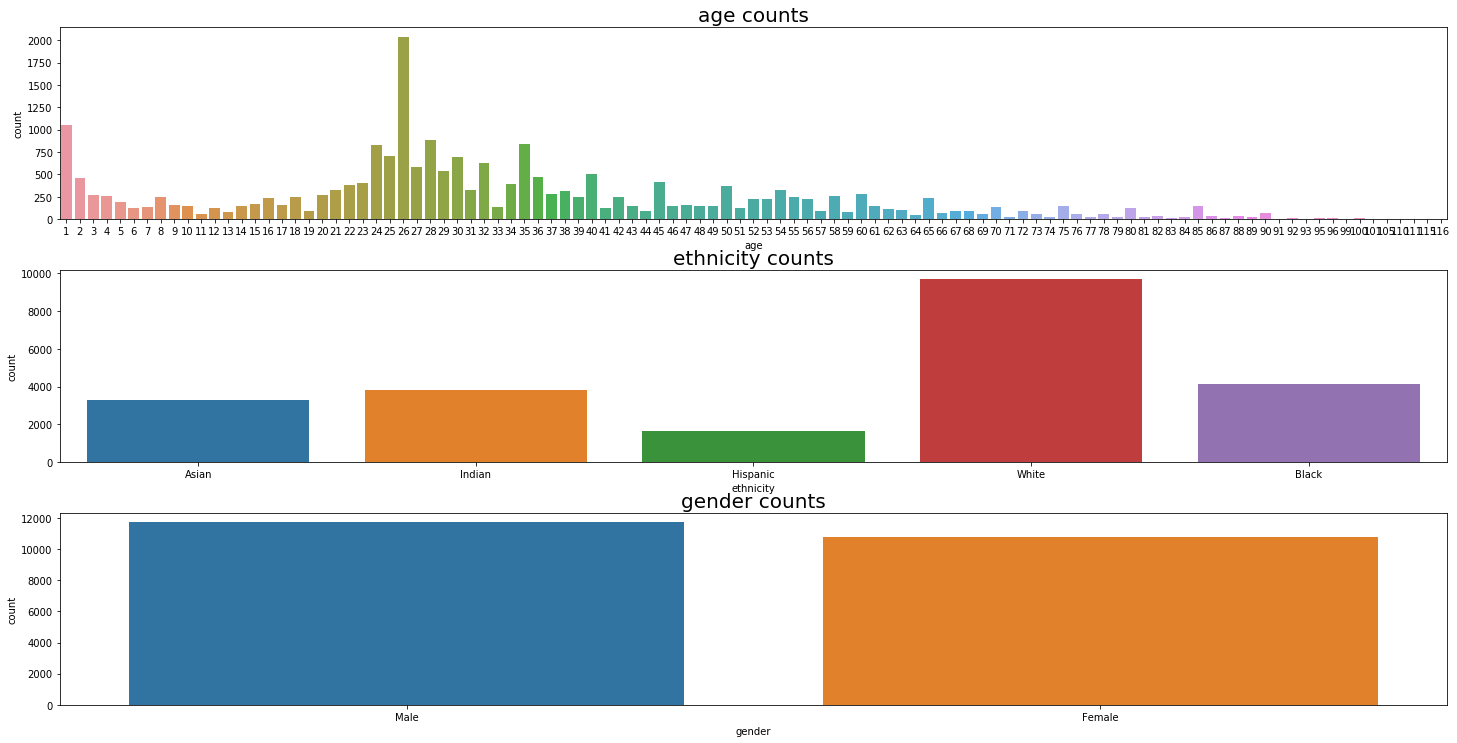

In [6]:
def plot_metrics():
    fig,axs = plt.subplots(3,1,figsize=(20,10))
    fig.tight_layout(h_pad=3)
    for i,col in enumerate(["age","ethnicity","gender"]):
        sns.countplot(data[col],ax = axs[i])
        axs[i].set_title(col+" counts",size=20)
    plt.show
    return
plot_metrics()

## Lots of 26 year olds and White people. This imbalance in our data will affect our findings so we need to be congnizant of that.



In [7]:
def get_photo(img_path):
    return cv2.resize(cv2.imread(img_path), (224, 224), interpolation=cv2.INTER_LINEAR)

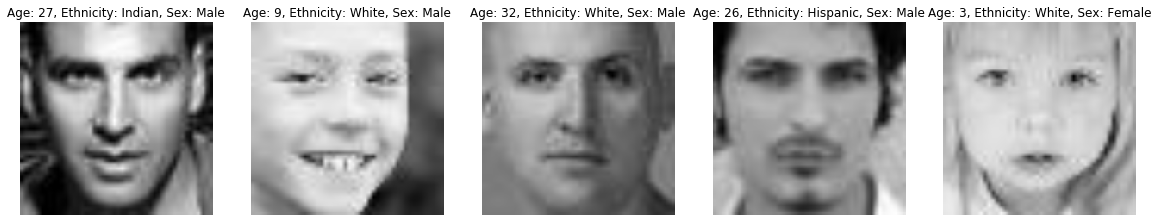

In [8]:
def n_random_faces(n):
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    folder = r"images"
    for i in range(n):
        row = data.sample().reset_index()
        axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(row["age"][0], row['ethnicity'][0], row["gender"][0]))
        axes[i].imshow(get_photo(row['path'][0]))
        axes[i].axis('off')
    return
n_random_faces(5)

In [9]:
# has_landmarks = data.copy()
# landmarks = []
# for i,path in enumerate(data["path"]):
#     try:
#         landmarks.append(extract_face_landmarks(get_photo(path)).tolist())
#     except FileNotFoundError:
#         has_landmarks = has_landmarks.drop(i) 
#     except AttributeError:
#         has_landmarks = has_landmarks.drop(i)
# has_landmarks["landmarks"] = landmarks
# has_landmarks

In [10]:
# has_landmarks.to_csv("resized_has_landmarks.csv",index=False)

## Here's a biggie, there are indeces missing cause they don't have landmarks. Keep this in mind when iterating through data please.

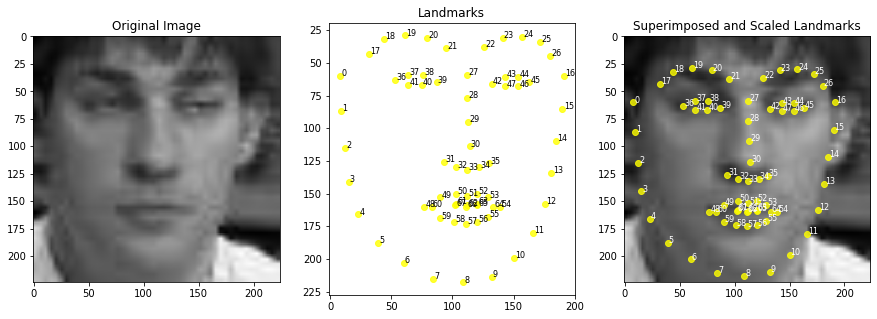

[[8, 60],
 [9, 87],
 [12, 115],
 [15, 141],
 [23, 166],
 [39, 188],
 [60, 203],
 [84, 215],
 [109, 218],
 [132, 214],
 [150, 199],
 [166, 180],
 [176, 158],
 [181, 134],
 [185, 110],
 [190, 85],
 [191, 60],
 [32, 43],
 [44, 32],
 [61, 29],
 [79, 31],
 [95, 39],
 [126, 38],
 [141, 31],
 [157, 30],
 [172, 34],
 [180, 45],
 [112, 59],
 [112, 77],
 [113, 95],
 [114, 114],
 [93, 126],
 [103, 130],
 [112, 132],
 [122, 130],
 [130, 127],
 [53, 63],
 [64, 59],
 [76, 59],
 [87, 65],
 [75, 67],
 [64, 67],
 [132, 66],
 [143, 61],
 [154, 61],
 [163, 65],
 [154, 68],
 [143, 68],
 [77, 160],
 [90, 153],
 [103, 150],
 [112, 152],
 [120, 150],
 [129, 153],
 [139, 160],
 [129, 168],
 [120, 172],
 [111, 173],
 [101, 172],
 [90, 169],
 [83, 160],
 [103, 158],
 [112, 159],
 [120, 158],
 [133, 160],
 [120, 159],
 [111, 160],
 [102, 159]]

In [35]:
def display_landmarks(row):
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    landmarks = row["landmarks"]
    img = cv2.cvtColor(cv2.resize(cv2.imread(row["path"]), (224, 224), interpolation=cv2.INTER_LINEAR), cv2.COLOR_BGR2RGB)
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[1].scatter([point[0] for point in landmarks], [point[1] for point in landmarks], alpha=0.8,c="yellow")
    for i in range(len(landmarks)):
        ax[1].text(landmarks[i][0]+1, landmarks[i][1], str(i), size=8)
    ax[1].set_title("Landmarks")
    ax[1].set_ylim(ax[1].get_ylim()[::-1])
    img2 = img.copy()
    ax[2].imshow(img2)
    ax[2].scatter([point[0] for point in landmarks], [point[1] for point in landmarks], alpha=0.8,c="yellow")
    for i in range(len(landmarks)):
        ax[2].text(landmarks[i][0]+1, landmarks[i][1], str(i), size=8,c="white")
    ax[2].set_title("Superimposed and Scaled Landmarks")
    plt.show()
    return landmarks

display_landmarks(data.iloc[11724])

## Features to consider

Tip of nose to top of lip: [33,50]

Bottom of lip to bottom of chin: [57,8]

Inner corner of eyes: [39,42]

Eyelid length:[36,39] and [42,45]

Face Width: [0,16]

Nose Width: [31,35]

Angle of Mouth:[48,54] and 66

Size of Mouth: [48,54]

Length of Nose: [33,28]

Width of bottom lip: [66,57]

Eye size:[38,41] and [43,47]




In [12]:
def calc_distance(point1,point2):
    return np.sqrt((point2[0]-point1[0])**2+(point2[1]-point1[1])**2)

In [18]:
feature_dictionary = {
    "nose2lip":[33,50,"V"],
    "lip2chin":[57,8,"V"],
    "len_between_eyes":[39,42,"H"],
    "left_eyelid_len":[19,37,"V"],
    "right_eyelid_len":[24,44,"V"],
    "nose_width":[31,35,"H"],
    #"mouth_angle":[48,54] 66 center
    "size_of_mouth":[48,54,"H"],
    "nose_len":[33,28,"V"],
    "bottom_lip_width":[66,57,"V"],
    "left_eye_size":[38,41,"V"],
    "right_eye_size":[43,47,"V"] 
}

In [19]:
def create_distance_feature(landmarks,point1,point2,orientation):
    if orientation=="V":
        normalization = calc_distance(landmarks[8],landmarks[22])
    else:
        normalization = calc_distance(landmarks[0],landmarks[16])
    return calc_distance(landmarks[point1],landmarks[point2])/normalization

In [21]:
def feature_dataframe(df):
    new_features=[]
    returnFrame = pd.DataFrame([],columns=feature_dictionary.keys())
    for face in df["landmarks"]:
        face_features =[]
        for metric in feature_dictionary.keys():
            value = feature_dictionary.get(metric)
            face_features.append(create_distance_feature(face,value[0],value[1],value[2]))
        new_features.append(face_features)
    return pd.DataFrame(new_features,columns=feature_dictionary.keys())

In [22]:
to_neural_net = data.join(feature_dataframe(data))
to_neural_net.to_csv("to_neural_net.csv",index=False)